In [101]:
import numpy as np                              
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            
sns.set()

from itertools import product                   
from tqdm import tqdm_notebook

import warnings                                  
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

plt.rcParams["figure.figsize"] = [12, 6]

In [102]:
df_m = pd.read_csv('A:/Data/Metro_Interstate_Traffic_Volume.csv', parse_dates=['date_time'])

In [103]:
df_m.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


#### Оставляю 4 колонки

In [104]:
df = df_m[['traffic_volume', 'date_time', 'holiday', 'temp']].copy()

In [105]:
df.head()

,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14


In [106]:
df.shape

(48204, 4)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   traffic_volume  48204 non-null  int64         
 1   date_time       48204 non-null  datetime64[ns]
 2   holiday         48204 non-null  object        
 3   temp            48204 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


#### Проверю пропуски 

In [108]:
df.isna().sum()

traffic_volume    0
date_time         0
holiday           0
temp              0
dtype: int64

In [109]:
df.describe()

,traffic_volume,temp
count,48204.000000,48204.000000
mean,3259.818355,281.205870
std,1986.860670,13.338232
min,0.000000,0.000000
25%,1193.000000,272.160000
50%,3380.000000,282.450000
75%,4933.000000,291.806000
max,7280.000000,310.070000


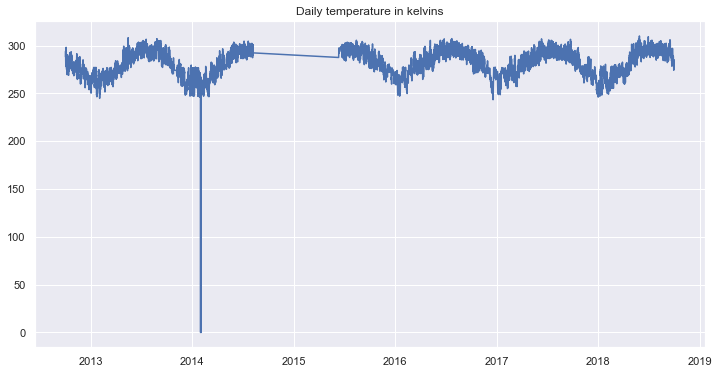

In [110]:

plt.plot(df.date_time, df.temp)
plt.title('Daily temperature in kelvins')
plt.grid(True)
plt.show()

#### Есть нулевые температуры,это явные выбросы.Заменю их на средние значения


In [111]:
df[df.temp==0.0].temp.count()

10

In [112]:
df[df.temp==0.0].temp = df.temp.mean()

<AxesSubplot:>

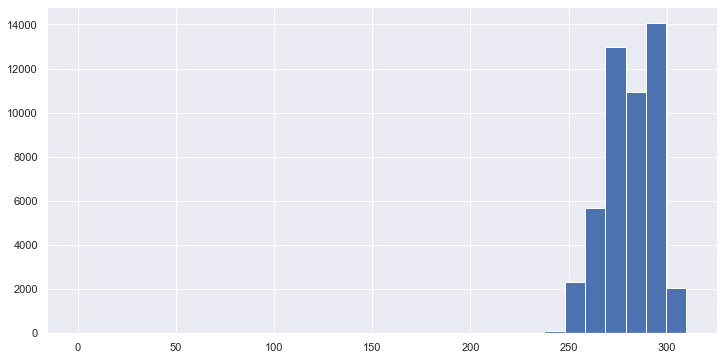

In [113]:
df.temp.hist(bins=30)

##### Получилось

#### Проверю праздники

In [114]:
df.holiday.value_counts()

None                         48143
Labor Day                        7
New Years Day                    6
Christmas Day                    6
Thanksgiving Day                 6
Martin Luther King Jr Day        6
State Fair                       5
Veterans Day                     5
Independence Day                 5
Columbus Day                     5
Washingtons Birthday             5
Memorial Day                     5
Name: holiday, dtype: int64

In [115]:
df.holiday.value_counts()

None                         48143
Labor Day                        7
New Years Day                    6
Christmas Day                    6
Thanksgiving Day                 6
Martin Luther King Jr Day        6
State Fair                       5
Veterans Day                     5
Independence Day                 5
Columbus Day                     5
Washingtons Birthday             5
Memorial Day                     5
Name: holiday, dtype: int64

#### Проверю датафрейм на дубликаты

In [116]:
df.duplicated().value_counts()

False    40653
True      7551
dtype: int64

#### Удаляю дубликаты

In [117]:
df = df.drop_duplicates(keep=False)
df

,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14
...,...,...,...,...
48199,3543,2018-09-30 19:00:00,None,283.45
48200,2781,2018-09-30 20:00:00,None,282.76
48201,2159,2018-09-30 21:00:00,None,282.73
48202,1450,2018-09-30 22:00:00,None,282.09


In [118]:
df.duplicated().value_counts()

False    35261
dtype: int64

In [119]:
df.isnull().sum()

traffic_volume    0
date_time         0
holiday           0
temp              0
dtype: int64

#### Всё в порядке,дубликатов нет,пропущенных значений нет

#### Посмотрю целевую переменную

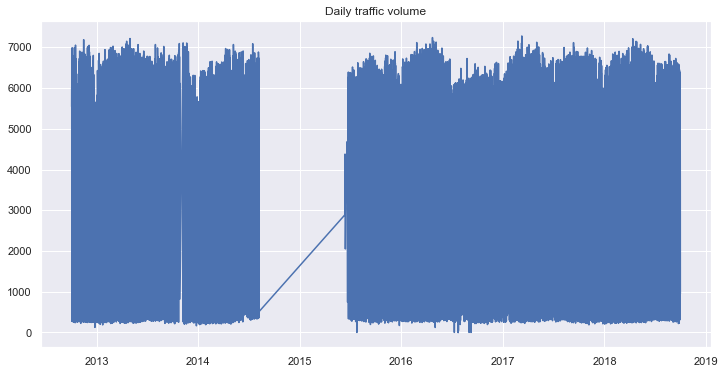

In [120]:
plt.plot(df.date_time, df.traffic_volume)
plt.title('Daily traffic volume')
plt.grid(True)
plt.show()

#### Есть пропуск в данных.Значений достаточно для анализа,поэтому возьму только правую часть

In [121]:
df_short = df[df.date_time.dt.year>2015]

In [122]:
df_short.shape

(19702, 4)

In [123]:
#df_final['holiday'] = df_final['holiday'].apply(lambda x: 0 if x=='None' else 1)

#### Выравниваю интервалы и интерполирую

In [124]:
df_short.date_time.min()

Timestamp('2016-01-01 01:00:00')

In [125]:
df_short.date_time.max()

Timestamp('2018-09-30 23:00:00')

In [126]:
df_final = \
pd.merge(
    pd.Series(pd.date_range(df_short.date_time.min(), df_short.date_time.max(), freq='h'), name='date_time'),
    df_short,
    how="left",
    on = "date_time"
).interpolate()

In [127]:
df_final.shape

(24137, 4)

In [128]:
df_final.value_counts()

date_time            traffic_volume  holiday  temp  
2018-09-30 23:00:00  954.0           None     282.12    1
2016-12-18 23:00:00  1033.0          None     254.14    1
2016-12-18 16:00:00  3869.0          None     251.15    1
2016-12-18 17:00:00  3714.0          None     250.08    1
2016-12-18 19:00:00  2502.0          None     250.22    1
                                                       ..
2017-11-10 22:00:00  2467.0          None     269.23    1
2017-11-10 23:00:00  1739.0          None     268.79    1
2017-11-11 03:00:00  541.0           None     270.61    1
2017-11-11 04:00:00  555.0           None     271.00    1
2016-01-01 01:00:00  1550.0          None     266.00    1
Length: 19702, dtype: int64

In [129]:
df_final['holiday'].value_counts()

None                    19680
State Fair                  3
Independence Day            3
Washingtons Birthday        3
Memorial Day                3
Veterans Day                2
Columbus Day                2
Thanksgiving Day            2
New Years Day               2
Christmas Day               1
Labor Day                   1
Name: holiday, dtype: int64

#### Сделаю переменную "holiday" бинарной

In [130]:
df_final['holiday'] = df_final['holiday'].apply(lambda x: 0 if x=='None' else 1)

In [131]:
df_final['holiday'].value_counts()

0    19680
1     4457
Name: holiday, dtype: int64

In [132]:
df_final.head()

,date_time,traffic_volume,holiday,temp
0,2016-01-01 01:00:00,1550.0,0,266.000
1,2016-01-01 02:00:00,1134.5,1,266.005
2,2016-01-01 03:00:00,719.0,0,266.010
3,2016-01-01 04:00:00,533.0,0,264.800
4,2016-01-01 05:00:00,586.0,0,264.380


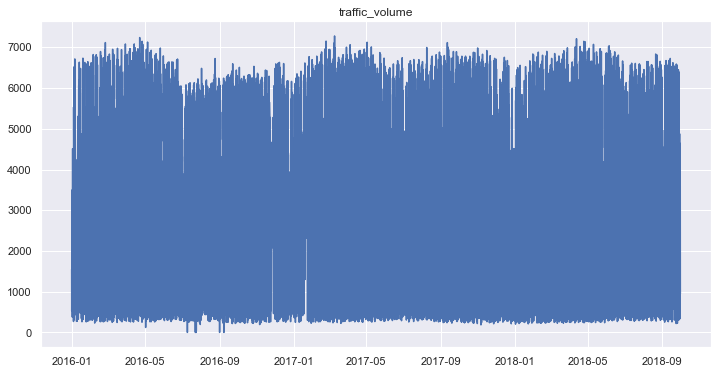

In [137]:
plt.figure(figsize=(12, 6))
plt.plot(df_final.date_time, df_final.traffic_volume)
plt.title('traffic_volume')
plt.grid(True)
plt.show()

In [138]:
df_final["hour"] = df_final.index.hour
df_final["weekday"] = df_final.index.weekday
df_final['is_weekend'] = df_final.weekday.isin([5,6])*1
df_final.tail()

AttributeError: 'Int64Index' object has no attribute 'hour'